In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pickle
from sklearn.ensemble import RandomForestClassifier

In [2]:
def load_data(path, subject):
    """Given path and subject, load the data of the subject"""
    data = pd.read_pickle(path)
    return data

In [3]:
class read_data_one_subject:
    """Read data from WESAD dataset"""
    def __init__(self, path, subject):
        self.keys = ['label', 'subject', 'signal']
        self.signal_keys = ['wrist']
        self.wrist_sensor_keys = ['ACC', 'BVP', 'EDA', 'TEMP', 'HR']
        data = pd.read_pickle(path)
        self.data = data

    def get_labels(self):
        return self.data[self.keys[0]]

    def get_wrist_data(self):
        """"""
        signal = self.data[self.keys[2]]
        wrist_data = signal[self.signal_keys[0]]
        return wrist_data

In [4]:
def clean_data_to_df(i):
    data_set_path = 'data/WESAD/'+i+'/'+i+'.pkl'
    subject = i
    obj_data = {}
    labels = {}
    wrist_data = {}
    subs = [2]

    print("Reading data", subject)
    obj_data[subject] = read_data_one_subject(data_set_path, subject)
    labels[subject] = obj_data[subject].get_labels()

    wrist_data_dict = obj_data[subject].get_wrist_data()
    wrist_dict_length = {key: len(value) for key, value in wrist_data_dict.items()}
    wrist_data[subject] = wrist_data_dict
    print(wrist_data_dict)
    print(wrist_dict_length)

    print(wrist_data[subject]["ACC"].shape)
    print(wrist_data[subject]["BVP"].shape)
    print(wrist_data[subject]["EDA"].shape)
    print(wrist_data[subject]["TEMP"].shape)
    print(labels[subject].shape)

    acc_data = list(wrist_data[subject]["ACC"])
    acc_count = len(acc_data)*2
    for i in range(0, acc_count, 2):
      acc_reading = acc_data[i]
      acc_data.insert(i+1, acc_reading)
    wrist_data[subject]["ACC"] = np.array(acc_data)
    print(wrist_data[subject]["ACC"].shape)

    bvp_data = list(wrist_data[subject]["BVP"])
    for i in range(len(bvp_data)):
      bvp_reading = bvp_data[i][0]
      bvp_data[i]= bvp_reading
    wrist_data[subject]["BVP"] = np.array(bvp_data)
    print(wrist_data[subject]["BVP"].shape)

    eda_data = list(wrist_data[subject]["EDA"])
    eda_count = len(eda_data)*16
    for i in range(0, eda_count, 16):
        eda_reading = eda_data[i][0]
        eda_data[i] = eda_reading
        idx=i+1
        for k in range(15):
            eda_data.insert(idx, eda_reading)
            idx+=1
    wrist_data[subject]["EDA"] = np.array(eda_data)
    print(wrist_data[subject]["EDA"].shape)

    temp_data = list(wrist_data[subject]["TEMP"])
    temp_count = len(temp_data)*16
    for i in range(0, temp_count, 16):
        temp_reading = temp_data[i][0]
        temp_data[i] = temp_reading
        idx=i+1
        for k in range(15):
            temp_data.insert(idx, temp_reading)
            idx+=1
    wrist_data[subject]["TEMP"] = np.array(temp_data)
    print(wrist_data[subject]["TEMP"].shape)

    label_new = []
    label_data = labels[subject]
    for i in range(1,temp_count+1):
      sampled_label = label_data[i*10]
      label_new.append(sampled_label)

    labels[subject] = np.array(label_new)
    print(labels[subject].shape)

    # split acc to 3 arrays acc_x, acc_y, acc_z

    acc_data = wrist_data[subject]["ACC"]
    acc_x = []
    acc_y = []
    acc_z = []
    for i in range(acc_data.shape[0]):
      acc_reading = acc_data[i]
      acc_x_reading = acc_reading[0]
      acc_y_reading = acc_reading[1]
      acc_z_reading = acc_reading[2]
      acc_x.append(acc_x_reading)
      acc_y.append(acc_y_reading)
      acc_z.append(acc_z_reading)

    acc_x = np.array(acc_x)
    acc_y = np.array(acc_y)
    acc_z = np.array(acc_z)

    wrist_data[subject]["ACC_X"] = acc_x
    wrist_data[subject]["ACC_Y"] = acc_y
    wrist_data[subject]["ACC_Z"] = acc_z

    # change 1,3,4,5,6,7 labels to 0 and label 2 to 1
    for i in range(labels[subject].shape[0]):
      if labels[subject][i]!=2:
        labels[subject][i]=0
      else:
        labels[subject][i]=1

    print(wrist_data[subject]["ACC_X"].shape)
    print(wrist_data[subject]["ACC_Y"].shape)
    print(wrist_data[subject]["ACC_Z"].shape)
    print(wrist_data[subject]["BVP"].shape)
    print(wrist_data[subject]["EDA"].shape)
    print(wrist_data[subject]["TEMP"].shape)
    print(labels[subject].shape)

    # upsampling of stress data points
    df = pd.DataFrame({
        "ACC_X":wrist_data[subject]['ACC_X'],
        "ACC_Y":wrist_data[subject]['ACC_Y'],
        "ACC_Z":wrist_data[subject]['ACC_Z'],
        "BVP":wrist_data[subject]['BVP'],
        "EDA":wrist_data[subject]['EDA'],
        "TEMP":wrist_data[subject]['TEMP']    
                       })
    df['labels'] = labels[subject]
    
    return df

In [5]:
def find_merge_index(df_bvp, df_pickle):
    first_rows = df.iloc[0:10, 3]
    for i, row in tqdm(df_bvp.iterrows(), total=df_bvp.shape[0]):
        rows = df_bvp.iloc[i:i+10, 0]
        if set(first_rows)==set(rows):
            return i

In [6]:
def merge_hr_pickle(df_bvp, df_hr, df_pickle, merge_index):
    bvp_start_time = float(df_bvp.columns[0])
    hr_start_time = float(df_hr.columns[0])
    
    start_delay = float(merge_index/64)
    
    total_time = int(len(df_pickle)/64)
    
    
    if bvp_start_time>hr_start_time:
        hr_start_index = math.ceil(start_delay-(bvp_start_time-hr_start_time))
    else:
        hr_start_index = math.ceil(start_delay-(hr_start_time-bvp_start_time))
        
    df_hr_subset = df_hr.iloc[hr_start_index:hr_start_index+total_time]
    
    df_hr_new = pd.DataFrame(np.repeat(df_hr_subset.values, 64, axis=0))
    
    df_pickle['hr'] = df_hr_new.values
    
    return df_pickle

## Preprocessing the raw data into a DataFrame for modeling

In [7]:
subjects = ['S10', 'S11', 'S13', 'S14', 'S15', 'S16', 'S17', 'S2', 'S3', 'S4', 'S5','S6','S7','S8','S9']

for i in tqdm(subjects):
    print(i)
    df = clean_data_to_df(i)
    df_bvp = pd.read_csv('data/WESAD/'+i+'/'+i+'_E4_Data/BVP.csv')
    df_bvp = df_bvp.iloc[1:]
    df_hr = pd.read_csv('data/WESAD/'+i+'/'+i+'_E4_Data/HR.csv')
    df_hr = df_hr.iloc[1:]
    
    merge_index = find_merge_index(df_bvp, df)
    
    if i == 'S10':
        df_train = merge_hr_pickle(df_bvp, df_hr, df, merge_index)
    else:
        df_train = pd.concat([df_train, merge_hr_pickle(df_bvp, df_hr, df, merge_index)])

  0%|          | 0/15 [00:00<?, ?it/s]

S10
Reading data S10
{'ACC': array([[ 107., -105.,  127.],
       [  67.,  -52.,   45.],
       [  26.,   40.,    0.],
       ...,
       [  54.,   23.,   24.],
       [  54.,   23.,   24.],
       [  54.,   23.,   24.]]), 'BVP': array([[10.17],
       [12.04],
       [13.01],
       ...,
       [57.59],
       [65.93],
       [69.86]]), 'EDA': array([[0.349215],
       [0.346656],
       [0.350494],
       ...,
       [0.931574],
       [0.932854],
       [0.932854]]), 'TEMP': array([[33.13],
       [33.16],
       [33.16],
       ...,
       [30.83],
       [30.83],
       [30.83]])}
{'ACC': 175872, 'BVP': 351744, 'EDA': 21984, 'TEMP': 21984}
(175872, 3)
(351744, 1)
(21984, 1)
(21984, 1)
(3847200,)
(351744, 3)
(351744,)
(351744,)
(351744,)
(351744,)



  0%|          | 775/436645 [00:00<00:56, 7748.23it/s]

(351744,)
(351744,)
(351744,)
(351744,)
(351744,)
(351744,)
(351744,)



  7%|▋         | 1/15 [00:25<05:51, 25.08s/it]

S11
Reading data S11
{'ACC': array([[-128.,  127.,  127.],
       [ -46.,    2.,   92.],
       [ -82.,  -34.,    5.],
       ...,
       [ -42.,  -38.,  -21.],
       [ -25.,  -42.,  -18.],
       [ -31.,  -44.,  -13.]]), 'BVP': array([[-12.14],
       [ -6.2 ],
       [ -0.58],
       ...,
       [  5.76],
       [  5.48],
       [  5.1 ]]), 'EDA': array([[4.4455  ],
       [4.911148],
       [4.741007],
       ...,
       [1.860665],
       [1.842755],
       [1.946375]]), 'TEMP': array([[34.  ],
       [34.  ],
       [34.  ],
       ...,
       [31.53],
       [31.53],
       [31.53]])}
{'ACC': 167456, 'BVP': 334912, 'EDA': 20932, 'TEMP': 20932}
(167456, 3)
(334912, 1)
(20932, 1)
(20932, 1)
(3663100,)
(334912, 3)
(334912,)
(334912,)
(334912,)
(334912,)



  0%|          | 828/413468 [00:00<00:49, 8274.07it/s]

(334912,)
(334912,)
(334912,)
(334912,)
(334912,)
(334912,)
(334912,)



 13%|█▎        | 2/15 [00:48<05:09, 23.83s/it]

S13
Reading data S13
{'ACC': array([[ 54., -57., 127.],
       [ 35.,  50.,  40.],
       [  3.,  30.,  -2.],
       ...,
       [ 46.,  39.,  18.],
       [ 47.,  40.,  18.],
       [ 47.,  39.,  19.]]), 'BVP': array([[  44.2 ],
       [  42.39],
       [  40.48],
       ...,
       [-342.38],
       [-352.82],
       [-357.59]]), 'EDA': array([[9.149161],
       [8.816556],
       [8.713039],
       ...,
       [3.317144],
       [3.317144],
       [3.331215]]), 'TEMP': array([[34.71],
       [34.71],
       [34.68],
       ...,
       [34.05],
       [34.05],
       [34.05]])}
{'ACC': 177184, 'BVP': 354368, 'EDA': 22148, 'TEMP': 22148}
(177184, 3)
(354368, 1)
(22148, 1)
(22148, 1)
(3875900,)
(354368, 3)
(354368,)
(354368,)
(354368,)
(354368,)



  0%|          | 828/439208 [00:00<00:52, 8273.30it/s]

(354368,)
(354368,)
(354368,)
(354368,)
(354368,)
(354368,)
(354368,)



 20%|██        | 3/15 [01:12<04:51, 24.26s/it]

S14
Reading data S14
{'ACC': array([[ -23.,   31.,  127.],
       [-128.,  -31.,   62.],
       [ -54.,  -58.,   26.],
       ...,
       [ -47.,  -45.,    6.],
       [ -47.,  -44.,    8.],
       [ -47.,  -45.,    8.]]), 'BVP': array([[  -8.27],
       [  -9.52],
       [ -10.68],
       ...,
       [-123.97],
       [-160.08],
       [-195.94]]), 'EDA': array([[0.277864],
       [0.266351],
       [0.195992],
       ...,
       [0.080859],
       [0.060391],
       [0.175257]]), 'TEMP': array([[31.97],
       [31.97],
       [31.97],
       ...,
       [31.21],
       [31.21],
       [31.21]])}
{'ACC': 177536, 'BVP': 355072, 'EDA': 22192, 'TEMP': 22192}
(177536, 3)
(355072, 1)
(22192, 1)
(22192, 1)
(3883600,)
(355072, 3)
(355072,)
(355072,)
(355072,)
(355072,)



  0%|          | 834/447128 [00:00<00:53, 8332.68it/s]

(355072,)
(355072,)
(355072,)
(355072,)
(355072,)
(355072,)
(355072,)



 27%|██▋       | 4/15 [01:38<04:33, 24.90s/it]

S15
Reading data S15
{'ACC': array([[ 40., -45., 127.],
       [127.,  33.,  54.],
       [ 38.,  30.,  17.],
       ...,
       [ 16.,  16., -11.],
       [ 26., -50., 127.],
       [ 86.,  24.,  71.]]), 'BVP': array([[ 1.35],
       [ 1.15],
       [ 1.13],
       ...,
       [19.77],
       [18.51],
       [16.52]]), 'EDA': array([[0.220298],
       [0.170407],
       [0.189596],
       ...,
       [0.454401],
       [0.451842],
       [0.453121]]), 'TEMP': array([[29.79],
       [29.79],
       [29.79],
       ...,
       [29.11],
       [29.11],
       [29.07]])}
{'ACC': 168064, 'BVP': 336128, 'EDA': 21008, 'TEMP': 21008}
(168064, 3)
(336128, 1)
(21008, 1)
(21008, 1)
(3676400,)
(336128, 3)
(336128,)
(336128,)
(336128,)
(336128,)



  0%|          | 826/425139 [00:00<00:51, 8250.13it/s]

(336128,)
(336128,)
(336128,)
(336128,)
(336128,)
(336128,)
(336128,)



 33%|███▎      | 5/15 [02:02<04:06, 24.61s/it]

S16
Reading data S16
{'ACC': array([[ 86., -38., 112.],
       [-40.,  26.,  -5.],
       [ 90.,  40.,   0.],
       ...,
       [ 47.,  40.,   2.],
       [ 48.,  39.,   3.],
       [ 49.,  39.,   3.]]), 'BVP': array([[-1.6 ],
       [-2.09],
       [-2.72],
       ...,
       [94.31],
       [94.96],
       [84.97]]), 'EDA': array([[0.254602],
       [0.253322],
       [0.250763],
       ...,
       [0.405838],
       [0.409676],
       [0.412235]]), 'TEMP': array([[29.43],
       [29.43],
       [29.43],
       ...,
       [29.57],
       [29.57],
       [29.57]])}
{'ACC': 180192, 'BVP': 360384, 'EDA': 22524, 'TEMP': 22524}
(180192, 3)
(360384, 1)
(22524, 1)
(22524, 1)
(3941700,)
(360384, 3)
(360384,)
(360384,)
(360384,)
(360384,)



  0%|          | 829/454850 [00:00<00:54, 8282.82it/s]

(360384,)
(360384,)
(360384,)
(360384,)
(360384,)
(360384,)
(360384,)



 40%|████      | 6/15 [02:29<03:46, 25.22s/it]

S17
Reading data S17
{'ACC': array([[ -36.,  -38., -128.],
       [  -9.,   -9.,    2.],
       [ 113.,  -25.,   86.],
       ...,
       [ -38.,  -43.,  -93.],
       [   2.,  -52., -105.],
       [-128.,   86.,  127.]]), 'BVP': array([[-0.49],
       [-0.38],
       [-0.36],
       ...,
       [-4.43],
       [-5.44],
       [-6.21]]), 'EDA': array([[2.015176],
       [2.012617],
       [2.001103],
       ...,
       [0.78717 ],
       [0.784611],
       [0.783331]]), 'TEMP': array([[33.39],
       [33.37],
       [33.37],
       ...,
       [31.81],
       [31.81],
       [31.81]])}
{'ACC': 189440, 'BVP': 378880, 'EDA': 23680, 'TEMP': 23680}
(189440, 3)
(378880, 1)
(23680, 1)
(23680, 1)
(4144000,)
(378880, 3)
(378880,)
(378880,)
(378880,)
(378880,)



  0%|          | 828/462825 [00:00<00:55, 8273.42it/s]

(378880,)
(378880,)
(378880,)
(378880,)
(378880,)
(378880,)
(378880,)



 47%|████▋     | 7/15 [02:55<03:25, 25.71s/it]

S2
Reading data S2
{'ACC': array([[ 62., -21., 107.],
       [ 66.,  13.,  53.],
       [ 41.,   9.,  15.],
       ...,
       [ 41.,  25.,  11.],
       [ 39.,  27.,  22.],
       [ 56.,  26.,  10.]]), 'BVP': array([[-59.37],
       [-53.42],
       [-44.4 ],
       ...,
       [ 18.26],
       [ 18.68],
       [ 19.71]]), 'EDA': array([[1.138257],
       [1.125444],
       [1.011405],
       ...,
       [0.059208],
       [0.073303],
       [0.045113]]), 'TEMP': array([[35.41],
       [35.41],
       [35.41],
       ...,
       [34.23],
       [34.23],
       [34.23]])}
{'ACC': 194528, 'BVP': 389056, 'EDA': 24316, 'TEMP': 24316}
(194528, 3)
(389056, 1)
(24316, 1)
(24316, 1)
(4255300,)
(389056, 3)
(389056,)
(389056,)
(389056,)
(389056,)



  0%|          | 831/503943 [00:00<01:00, 8309.24it/s]

(389056,)
(389056,)
(389056,)
(389056,)
(389056,)
(389056,)
(389056,)



 53%|█████▎    | 8/15 [03:25<03:08, 26.97s/it]

S3
Reading data S3
{'ACC': array([[-128.,  127.,  127.],
       [ -41.,   49.,   76.],
       [  -3.,   14.,   14.],
       ...,
       [ -55.,  -34.,   12.],
       [ -54.,  -34.,   11.],
       [ -54.,  -34.,   11.]]), 'BVP': array([[16.49],
       [15.8 ],
       [14.58],
       ...,
       [ 4.98],
       [ 4.74],
       [ 4.44]]), 'EDA': array([[2.248749],
       [2.710001],
       [2.554969],
       ...,
       [0.301362],
       [0.301362],
       [0.301362]]), 'TEMP': array([[31.73],
       [31.73],
       [31.73],
       ...,
       [30.81],
       [30.83],
       [30.83]])}
{'ACC': 207776, 'BVP': 415552, 'EDA': 25972, 'TEMP': 25972}
(207776, 3)
(415552, 1)
(25972, 1)
(25972, 1)
(4545100,)
(415552, 3)
(415552,)
(415552,)
(415552,)
(415552,)



  0%|          | 829/494307 [00:00<00:59, 8289.34it/s]

(415552,)
(415552,)
(415552,)
(415552,)
(415552,)
(415552,)
(415552,)



 60%|██████    | 9/15 [03:54<02:44, 27.45s/it]

S4
Reading data S4
{'ACC': array([[-128.,  122.,   88.],
       [ -31.,  -34.,   77.],
       [ -61.,    4.,   62.],
       ...,
       [   5.,  -29.,   55.],
       [   6.,  -29.,   56.],
       [   6.,  -28.,   56.]]), 'BVP': array([[  -3.69],
       [  -5.53],
       [  -7.82],
       ...,
       [-102.58],
       [-105.06],
       [-106.6 ]]), 'EDA': array([[0.169117],
       [0.164001],
       [0.167838],
       ...,
       [0.139696],
       [0.138417],
       [0.139696]]), 'TEMP': array([[32.53],
       [32.53],
       [32.53],
       ...,
       [31.37],
       [31.37],
       [31.37]])}
{'ACC': 205536, 'BVP': 411072, 'EDA': 25692, 'TEMP': 25692}
(205536, 3)
(411072, 1)
(25692, 1)
(25692, 1)
(4496100,)
(411072, 3)
(411072,)
(411072,)
(411072,)
(411072,)



  0%|          | 830/511962 [00:00<01:01, 8291.90it/s]

(411072,)
(411072,)
(411072,)
(411072,)
(411072,)
(411072,)
(411072,)



 67%|██████▋   | 10/15 [04:25<02:23, 28.61s/it]

S5
Reading data S5
{'ACC': array([[-16., -45., 127.],
       [ 69.,   9., 127.],
       [ 45.,  35., -12.],
       ...,
       [ 45.,  39.,  20.],
       [ 46.,  39.,  20.],
       [ 46.,  39.,  19.]]), 'BVP': array([[-7.25],
       [-8.57],
       [-9.48],
       ...,
       [-4.13],
       [-7.07],
       [-9.88]]), 'EDA': array([[0.547723],
       [0.481218],
       [0.518239],
       ...,
       [0.985122],
       [0.965938],
       [0.955706]]), 'TEMP': array([[34.09],
       [34.09],
       [34.09],
       ...,
       [31.03],
       [31.03],
       [31.01]])}
{'ACC': 200256, 'BVP': 400512, 'EDA': 25032, 'TEMP': 25032}
(200256, 3)
(400512, 1)
(25032, 1)
(25032, 1)
(4380600,)
(400512, 3)
(400512,)
(400512,)
(400512,)
(400512,)



  0%|          | 832/483241 [00:00<00:58, 8315.67it/s]

(400512,)
(400512,)
(400512,)
(400512,)
(400512,)
(400512,)
(400512,)



 73%|███████▎  | 11/15 [04:54<01:54, 28.65s/it]

S6
Reading data S6
{'ACC': array([[112., -19., 127.],
       [ 44.,  18.,  10.],
       [ 52.,  16.,  30.],
       ...,
       [ 38.,  32., -15.],
       [ 35.,  39., -37.],
       [ 48.,  45., -51.]]), 'BVP': array([[  4.26],
       [  3.12],
       [  1.7 ],
       ...,
       [-40.67],
       [-47.72],
       [-53.59]]), 'EDA': array([[2.779563],
       [2.785958],
       [2.761658],
       ...,
       [5.724445],
       [5.670729],
       [5.324135]]), 'TEMP': array([[30.03],
       [30.03],
       [30.03],
       ...,
       [32.61],
       [32.59],
       [32.59]])}
{'ACC': 226272, 'BVP': 452544, 'EDA': 28284, 'TEMP': 28284}
(226272, 3)
(452544, 1)
(28284, 1)
(28284, 1)
(4949700,)
(452544, 3)
(452544,)
(452544,)
(452544,)
(452544,)



  0%|          | 837/532708 [00:00<01:03, 8366.24it/s]

(452544,)
(452544,)
(452544,)
(452544,)
(452544,)
(452544,)
(452544,)



 80%|████████  | 12/15 [05:26<01:29, 29.85s/it]

S7
Reading data S7
{'ACC': array([[127., -50., 127.],
       [127.,  46.,  -8.],
       [ 90.,  24.,  57.],
       ...,
       [  9.,  17.,  59.],
       [ 11.,  17.,  59.],
       [ 10.,  17.,  59.]]), 'BVP': array([[  9.57],
       [  7.41],
       [  5.11],
       ...,
       [-29.52],
       [-28.97],
       [-28.04]]), 'EDA': array([[5.969716],
       [6.1002  ],
       [6.096362],
       ...,
       [4.767331],
       [4.762214],
       [4.764772]]), 'TEMP': array([[33.25],
       [33.25],
       [33.25],
       ...,
       [31.23],
       [31.23],
       [31.23]])}
{'ACC': 167616, 'BVP': 335232, 'EDA': 20952, 'TEMP': 20952}
(167616, 3)
(335232, 1)
(20952, 1)
(20952, 1)
(3666600,)
(335232, 3)
(335232,)
(335232,)
(335232,)
(335232,)



  0%|          | 832/415646 [00:00<00:49, 8312.32it/s]

(335232,)
(335232,)
(335232,)
(335232,)
(335232,)
(335232,)
(335232,)



 87%|████████▋ | 13/15 [05:49<00:55, 27.80s/it]

S8
Reading data S8
{'ACC': array([[  -7.,  -15.,  -34.],
       [ -38.,  127.,  127.],
       [ 127.,  -48.,  127.],
       ...,
       [  62.,  -22.,  -93.],
       [-128.,  127.,  127.],
       [ 127.,   62.,  127.]]), 'BVP': array([[-3.27],
       [ 6.25],
       [13.86],
       ...,
       [ 4.59],
       [ 3.35],
       [ 1.99]]), 'EDA': array([[0.503081],
       [0.515874],
       [0.799868],
       ...,
       [0.270188],
       [0.270188],
       [0.271468]]), 'TEMP': array([[33.25],
       [33.25],
       [33.29],
       ...,
       [31.59],
       [31.61],
       [31.61]])}
{'ACC': 174912, 'BVP': 349824, 'EDA': 21864, 'TEMP': 21864}
(174912, 3)
(349824, 1)
(21864, 1)
(21864, 1)
(3826200,)
(349824, 3)
(349824,)
(349824,)
(349824,)
(349824,)



  0%|          | 808/424864 [00:00<00:52, 8076.00it/s]

(349824,)
(349824,)
(349824,)
(349824,)
(349824,)
(349824,)
(349824,)



 93%|█████████▎| 14/15 [06:13<00:26, 26.64s/it]

S9
Reading data S9
{'ACC': array([[-128.,  -55.,  127.],
       [-128.,   -3.,   85.],
       [  30.,   75.,   56.],
       ...,
       [  28.,   50.,   23.],
       [   3.,   60.,   39.],
       [ -26.,   29.,   50.]]), 'BVP': array([[-10.02],
       [ -7.43],
       [ -4.57],
       ...,
       [ 29.07],
       [ 27.74],
       [ 25.88]]), 'EDA': array([[0.329014],
       [0.326456],
       [0.336689],
       ...,
       [0.496586],
       [0.497865],
       [0.496586]]), 'TEMP': array([[33.87],
       [33.87],
       [33.87],
       ...,
       [31.97],
       [31.97],
       [31.97]])}
{'ACC': 167136, 'BVP': 334272, 'EDA': 20892, 'TEMP': 20892}
(167136, 3)
(334272, 1)
(20892, 1)
(20892, 1)
(3656100,)
(334272, 3)
(334272,)
(334272,)
(334272,)
(334272,)



  0%|          | 803/398629 [00:00<00:49, 8028.13it/s]

(334272,)
(334272,)
(334272,)
(334272,)
(334272,)
(334272,)
(334272,)



100%|██████████| 15/15 [06:35<00:00, 26.35s/it]


In [8]:
df_train.drop(columns=['ACC_X','ACC_Y','ACC_Z','BVP'], inplace=True)
df_train.reset_index(inplace=True)
drop_rows = [x for x in range(len(df_train)) if x%64!=0]
df_train.drop(drop_rows, axis=0, inplace=True)

In [9]:
df_train

,index,EDA,TEMP,labels,hr
0,0,0.349215,33.13,0,97.78
64,64,0.338981,33.16,0,98.05
128,128,0.336423,33.15,0,98.42
192,192,0.336423,33.16,0,98.80
256,256,0.335144,33.15,0,99.17
...,...,...,...,...,...
5559232,333952,0.494028,31.95,0,78.65
5559296,334016,0.486353,31.95,0,78.77
5559360,334080,0.499144,31.93,0,78.93
5559424,334144,0.502982,31.95,0,79.37


In [32]:
x_train, x_test, y_train, y_test = train_test_split(df_train, df_train['labels'], test_size = 0.25, stratify = df_train['labels'])

In [33]:
stress = x_train[x_train['labels']==1]
not_stress = x_train[x_train['labels']==0]

## Upsampling the data for class imbalance

In [34]:
from sklearn.utils import resample

stress = resample(stress, replace=True, n_samples=len(not_stress))

In [35]:
x_train = pd.concat([stress, not_stress])
x_train = x_train.sample(frac=1)
x_train

,index,EDA,TEMP,labels,hr
3449280,173184,0.155047,32.97,0,67.15
265280,265280,1.482998,33.03,1,81.30
2982080,121536,0.380799,33.07,0,79.38
4936000,60544,0.266351,33.66,0,71.60
5137600,262144,0.723112,32.33,1,77.78
...,...,...,...,...,...
3090176,229632,0.716557,31.23,0,77.38
4778688,238464,7.089770,32.55,1,87.53
2653504,182016,1.118938,32.65,1,64.78
5187200,311744,0.279143,32.07,0,73.03


In [36]:
y = x_train['labels']
X = x_train.drop(columns=['labels', 'index'])

In [37]:
X

,EDA,TEMP,hr
3449280,0.155047,32.97,67.15
265280,1.482998,33.03,81.30
2982080,0.380799,33.07,79.38
4936000,0.266351,33.66,71.60
5137600,0.723112,32.33,77.78
...,...,...,...
3090176,0.716557,31.23,77.38
4778688,7.089770,32.55,87.53
2653504,1.118938,32.65,64.78
5187200,0.279143,32.07,73.03


## Fitting a RandomForest model

In [38]:
clf = RandomForestClassifier()

clf.fit(X,y)

RandomForestClassifier()

In [39]:
x_test.drop(columns = ['index', 'labels'], inplace=True)

In [40]:
y_pred = clf.predict(x_test)

## Test metrics for our model

In [41]:
sum(y_pred==y_test)/len(y_test)*100

99.198784362481

In [42]:
y_test.reset_index(drop = True, inplace=True)



tp = 0
tn = 0 
fp = 0
fn = 0
for i in range(len(y_pred)):
  if (y_pred[i] == 1) and (y_test[i] == 1):
    tp = tp+1
  elif (y_pred[i] == 0) and (y_test[i] == 0):
    tn = tn+1
  elif (y_pred[i] == 1) and (y_test[i] == 0):
    fp = fp+1
  else:
    fn = fn+1
    

print('precision', tp/(tp+fp)*100)
print('recall', tp/(tp+fn)*100)

precision 96.63619744058501
recall 96.99082568807339


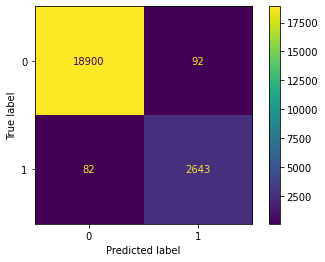

In [43]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf.classes_)
disp.plot()

plt.show()